# Modeling Cross Section Data with Decision Trees and Random Forest

In [296]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_style("darkgrid")

In [330]:
from Utilities import EXFOR_utilities as exfor_utils
from Utilities import ENDF_utilities as endf_utils
from Utilities import Plotting_utilities as plot_utils
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
print("Finish importing scripts.")

Finish importing scripts.


# Loading Normalized One-Hot Encoded Training, Validation, and Testing Datasets

In [298]:
log_E = False

In [299]:
# means dataset energy will be as log(E)
# df, df_plotting, x_train, x_test, y_train, y_test, to_scale, scaler = exfor_utils.load_exfor(
#     ("../ML_Data/working_xs_v2_unraw.csv"), num=True, plot_df=True, split=True, norm=True, log_e=log_E)
df, x_train, x_test, y_train, y_test, to_scale, scaler = exfor_utils.load_exfor(
    ("../../ML_Data/working_p_xs_v1.csv"), num=True, plot_df=False, split=True, norm=True, log_e=log_E, frac=0.50)

Reading data into dataframe...
Data read into dataframe with shape:  (59066, 88)
Dropping unnecessary features and one-hot encoding categorical columns...
Splitting dataset into training and testing...
Normalizing dataset...


/opt/anaconda3/envs/turi/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Finished. Resulting dataset has shape  (59066, 133) 
Training and Testing dataset shapes are (29533, 85) and (29533, 85) respesctively.


# Sampling Chlorine (n,p) and (n,g) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [300]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": False, "scaler": scaler, "to_scale": to_scale}
# copper = df[(df.Target_Protons == 29) & (df.Target_Neutrons == 36) & (df.MT == "4")]
# copper.shape
copper = exfor_utils.load_exfor_samples(df, 29, 65, "MT_4", **kwargs)

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (919, 133)


In [301]:
copper.shape

(919, 133)

# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

In [302]:
# new_cl_data_kwargs = {"Z":17, "A":35, "MT":"MT_103", "append_exfor":True, "log_e":log_E}
# new_cl_data = exfor_utils.load_exfor_newdata("./ENDF/Chlorine_Data/new_cl_np.csv", df=df, **new_cl_data_kwargs)
# new_cl_data.head()

# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [303]:
# endf_cl = endf_utils.load_endf("./ENDF/Chlorine_Data/endf_Cl_np_all.csv", log_e=log_E)
# endf_u = endf_utils.load_endf("./ENDF/Uranium_Data/endf_U_tot.csv", mev_to_ev=True, log_e=log_E)

# Visualizing Chlroine (n,p) Data

In [304]:
figure_dir="./Figures/"

In [305]:
# df[df.index.isin(x_train.index)]

In [306]:
# exfor_utils.plot_exfor_w_references(df[df.index.isin(x_train.index)], 17, 35, "MT_103", nat_iso="I", new_data=new_data, endf=endf_cl, error=True, 
#                                     save=False, interpolate=False, legend=False, alpha=0.7, one_hot=True, 
#                                     log_e=True, path=figure_dir, ref=False)

# Creating Chlorine and Uranium ONLY data

In [341]:
# Chlorine for Training and Testing (Single Isotope)
x_copper = copper.drop(columns=["Data"])
x_copper = x_copper[x]
x_copper[to_scale] = scaler.transform(x_copper[to_scale])
y_copper = copper["Data"]
x_cu_train, x_cu_test, y_cu_train, y_cu_test = train_test_split(x_copper, y_copper, test_size=0.20, random_state=0)

# Only Energy
x_cu_en = x_copper[["Energy"]]

In [342]:
# # Chlorine for Training and Testing (Single Isotope)
# x_u = uranium_235_nt.drop(columns=["Data"])
# x_u[to_scale] = scaler.transform(x_u[to_scale])
# y_u = uranium_235_nt["Data"]
# x_u_train, x_u_test, y_u_train, y_u_test = train_test_split(x_u, y_u, test_size=0.20, random_state=0)

# # Only Energy
# x_u_en = x_u[["Energy"]]

# Nearest Neighbors Regression

In [309]:
from sklearn.neighbors import KNeighborsRegressor

In [310]:
neigh_all = KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                            metric='minkowski', metric_params=None, n_jobs=-1)
neigh_all.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                    weights='uniform')

In [343]:
neigh = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                            metric='minkowski', metric_params=None, n_jobs=None)
neigh.fit(x_copper, y_copper)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [312]:
# %matplotlib qt
# import matplotlib.pyplot as plt

In [313]:
cl_kwargs =  {"Z":29, "A":65, "MT":"MT_4", "clf_type":None, "scaler":scaler, "to_scale":to_scale, 
              "E_min":0, "E_max":0, "N":0, "log_e":False, "show":True}

In [322]:
def load_exfor_samples(df, Z, A, MT, nat_iso="I", one_hot=True, scale=False, scaler=None, to_scale=[]):
    print("Extracting samples from dataframe.")
    if one_hot:
        sample = df[(df["Target_Protons"] == Z) & (df[MT] == 1) & (df["Target_Mass_Number"] == A) & 
                    (df["Target_Flag_" + nat_iso] == 1)].sort_values(by='Energy', ascending=True)
    else:
        sample = df[(df["Target_Protons"] == Z) & (df["MT"] == MT) & (df["Target_Mass_Number"] == A) & 
                    (df["Target_Flag"] == nat_iso)].sort_values(by='Energy', ascending=True)
    if scale:
        print("Scaling dataset...")
        sample[to_scale] = scaler.transform(sample[to_scale])
    print("EXFOR extracted DataFrame has shape: ", sample.shape)
    return sample

def make_predictions_outside(df, Z, A, MT, clf, clf_type, scaler, to_scale, E_min, E_max, N, log_e=False, show=False):
    # energy_range = pd.DataFrame({"Energy":np.linspace(E_min, E_max, N), "dEnergy":0})
    # to_infer = load_exfor_newdata("", new_df=energy_range, append_exfor=True, 
    #                                          df=df, Z=17, A=35, MT="MT_103", log_e=log_e)
    to_infer = load_exfor_samples(df, Z, A, MT)
    exfor = to_infer.copy()
    to_infer.drop(columns=["Data"], inplace=True)
    testing = list(to_infer.columns)
    x = testing[:20]
    y = testing[67:]
    x.extend(y)
    to_infer = to_infer[x]
    # to_infer = expanding_inference_dataset(to_infer, E_min, E_max, log_e, N)
#     if E_min != 0:
#         to_infer = expanding_inference_dataset(to_infer, E_min, E_max, log_e, N)
#     else:
#         to_infer = expanding_inference_dataset(to_infer, to_infer.Energy.min(), to_infer.Energy.max(), log_e, N) 
    # exfor = load_exfor_samples(df, Z, A, MT)
    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])

    # Make Predictions
    y_hat = make_predictions(to_infer.values, clf, clf_type)

    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
    if show:
        plt.scatter(exfor.Energy, exfor.Data, alpha=0.5, c="g")
        plt.plot(to_infer.Energy, y_hat)
#         plt.yscale('log')
        plt.xscale('log')
    return y_hat

def make_predictions(data, clf, clf_type):
    if clf_type == "tf":
        tf_dataset = tf.data.Dataset.from_tensor_slices((data)).batch(len(data))
        pred_vector = clf.predict(tf_dataset)
    elif clf_type == "xgb":
        xg_dataset = xgb.DMatrix(data)
        pred_vector = clf.predict(xg_dataset)
    else:
        pred_vector = clf.predict(data)
    return pred_vector

In [326]:
copper.Energy.max()

1820000000.0

In [324]:
df.Energy.max()

660000000000.0

In [332]:
cl_kwargs =  {"Z":29, "A":65, "MT":"MT_4", "clf_type":None, "scaler":scaler, "to_scale":to_scale, 
              "E_min":copper.Energy.max(), "E_max":df.Energy.max(), "N":500, "log_e":False, "show":True}

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (919, 133)


/opt/anaconda3/envs/turi/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2924: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


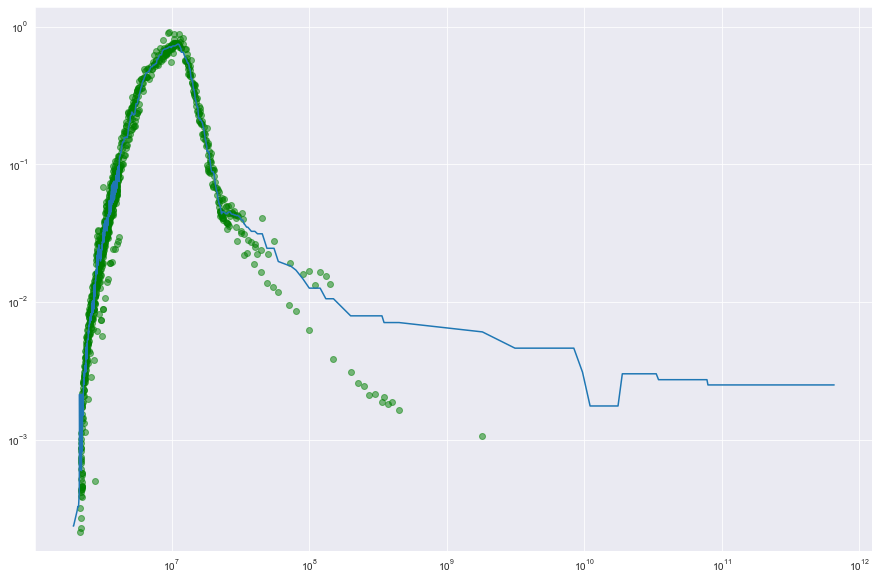

In [333]:
plt.figure(figsize=(15,10))
pred = exfor_utils.make_predictions_outside(df, clf=neigh_all, **cl_kwargs)

In [338]:
x_cu_train

,Energy,ELV/HL,dELV/HL,Target_Protons,Target_Neutrons,Target_Mass_Number,Target_Radius,Prot_Nuc_Rad_Ratio,Target_Mass_Excess,Target_dMass_Excess,Target_Binding_Energy,Target_dBinding_Energy,Target_B_Decay_Energy,Target_dB_Decay_Energy,Target_Atomic_Mass_Micro,Target_dAtomic_Mass_Micro,Target_S(2n),Target_dS(2n),Target_S(2p),Target_dS(2p),Target_Q(a),Target_dQ(a),Target_Q(2B-),Target_dQ(2B-),Target_Q(ep),Target_dQ(ep),Target_Q(B-n),Target_dQ(B-n),Target_S(n),Target_dS(n),Target_S(p),Target_dS(p),Target_Q(4B-),Target_dQ(4B-),"Target_Q(d,a)","Target_dQ(d,a)","Target_Q(p,a)","Target_dQ(p,a)","Target_Q(n,a)","Target_dQ(n,a)","Target_Q(g,p)","Target_Q(g,n)","Target_Q(g,pn)","Target_Q(g,d)","Target_Q(g,t)","Target_Q(g,He3)","Target_Q(g,2p)","Target_Q(g,2n)","Target_Q(g,a)","Target_Q(p,n)","Target_Q(p,2p)","Target_Q(p,pn)","Target_Q(p,d)","Target_Q(p,2n)","Target_Q(p,t)","Target_Q(p,3He)","Target_Q(n,2p)","Target_Q(n,np)","Target_Q(n,d)","Target_Q(n,2n)","Target_Q(n,t)","Target_Q(n,3He)","Target_Q(d,t)","Target_Q(d,3He)","Target_Q(3He,t)","Target_Q(3He,a)","Target_Q(t,a)",Target_Meta_State_All,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_111,MT_112,MT_115,MT_116,MT_117,MT_16,MT_191,MT_192,MT_193,MT_22,MT_28,MT_3,MT_4,MT_51,MT_114,MT_155,MT_17,MT_179,MT_190,MT_198,MT_44,MT_45,MT_109,MT_156,MT_165,MT_18,MT_23,MT_29,MT_37,MT_41,MT_42,MT_152,MT_153,MT_162,MT_24,MT_160,MT_161,MT_168,MT_25,I78_E,I78_L,I78_Other,I78_D,Product_Meta_State_All,Product_Meta_State_G,Product_Meta_State_M,Product_Meta_State_L,Product_Meta_State_+,Product_Meta_State_1,Product_Meta_State_2,Frame_C,Frame_L,Target_Flag_I,Target_Flag_N,Target_Origin_Other,Target_Origin_-n,Target_Origin_+n
28157,-0.728015,-0.224413,-0.224413,-0.007154,-0.001034,-0.00354,-0.007162,-0.035291,-0.53686,0.483661,0.983272,0.460572,0.382247,-0.793131,-0.00336,0.489738,-0.037132,-0.145012,0.0,1.448384,-6790.51,0.98,-4606.15,0.73,-14760.3,20.01,-9330.96,0.39,9910.43,0.67,7453.71,0.69,-20326.61,84.77,8959.92,0.67,4346.72,0.67,-192.98,18.58,-7453.71,-9910.43,-17111.1739,-14886.6079,-15467.1449,-20770.5994,-19990.16,-17826.54,-6790.51,-2133.9865,-7453.71,-9910.43,-7685.864,-10113.3065,-9344.7451,-9393.1335,-13977.9535,-7453.71,-5229.144,-9910.43,-8629.3789,-12272.1196,-3653.201,-1960.2356,-1370.232,10667.1894,12360.1549,0.0,-0.303839,-0.074037,-0.045867,-0.019303,-0.08956,-0.270529,-0.049091,-0.098713,-0.00823,0.0,-0.00823,-0.005819,-0.325737,-0.00823,0.0,-0.005819,-0.058288,-0.131632,-0.145104,1.072328,-0.223495,0.0,-0.005819,-0.247526,-0.022543,-0.027304,-0.036363,-0.020162,-0.023999,-0.00823,-0.019303,-0.011639,-0.230505,-0.00823,-0.010079,-0.180417,-0.024695,-0.026675,-0.133877,-0.064934,0.0,-0.023282,-0.038627,-0.00823,-0.005819,-0.010079,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0
28144,-0.741165,-0.224413,-0.224413,-0.007154,-0.001034,-0.00354,-0.007162,-0.035291,-0.53686,0.483661,0.983272,0.460572,0.382247,-0.793131,-0.00336,0.489738,-0.037132,-0.145012,0.0,1.448384,-6790.51,0.98,-4606.15,0.73,-14760.3,20.01,-9330.96,0.39,9910.43,0.67,7453.71,0.69,-20326.61,84.77,8959.92,0.67,4346.72,0.67,-192.98,18.58,-7453.71,-9910.43,-17111.1739,-14886.6079,-15467.1449,-20770.5994,-19990.16,-17826.54,-6790.51,-2133.9865,-7453.71,-9910.43,-7685.864,-10113.3065,-9344.7451,-9393.1335,-13977.9535,-7453.71,-5229.144,-9910.43,-8629.3789,-12272.1196,-3653.201,-1960.2356,-1370.232,10667.1894,12360.1549,0.0,-0.303839,-0.074037,-0.045867,-0.019303,-0.08956,-0.270529,-0.049091,-0.098713,-0.00823,0.0,-0.00823,-0.005819,-0.325737,-0.00823,0.0,-0.005819,-0.058288,-0.131632,-0.145104,1.072328,-0.223495,0.0,-0.005819,-0.247526,-0.022543,-0.027304,-0.036363,-0.020162,-0.023999,-0.00823,-0.019303,-0.011639,-0.230505,-0.00823,-0.010079,-0.180417,-0.024695,-0.026675,-0.133877,-0.064934,0.0,-0.023282,-0.038627,-0.00823,-0.005819,-0.010079,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0
28315,0.163833,-0.224413,-0.224413,-0.007154,-0.001034,-0.00354,-0.007162,-0.035291,-0.53686,0.483661,0.983272,0.460572,0.382247,-0.793131,-0.00336,0.48973

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (919, 133)


/opt/anaconda3/envs/turi/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2924: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


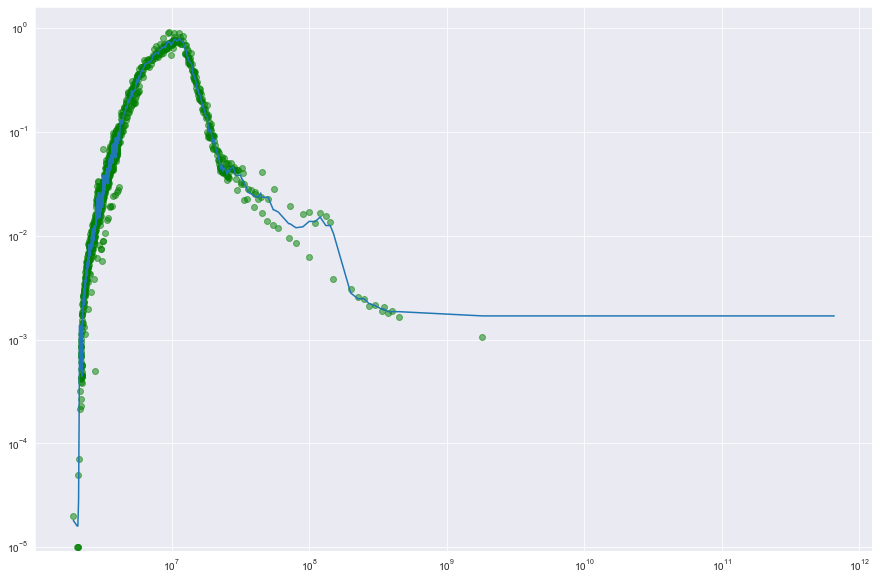

In [344]:
plt.figure(figsize=(15,10))
pred = exfor_utils.make_predictions_outside(df, clf=neigh, **cl_kwargs)

In [317]:
df.shape

(59066, 133)

In [318]:
df_without_train = df[df.index.isin(x_train.index)]

In [319]:
df_without_train.shape

(29533, 133)

In [320]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": False, "scaler": scaler, "to_scale": to_scale}
# copper = df[(df.Target_Protons == 29) & (df.Target_Neutrons == 36) & (df.MT == "4")]
# copper.shape
copper_train = exfor_utils.load_exfor_samples(df_without_train, 29, 65, "MT_4", **kwargs)

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (467, 133)


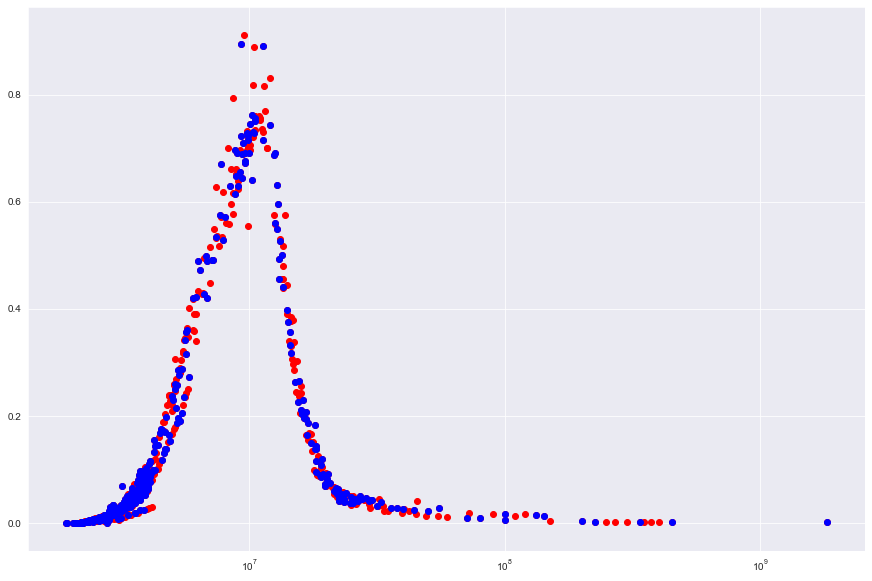

In [321]:
plt.figure(figsize=(15,10))
plt.scatter(copper.Energy, copper.Data, c='red')
plt.scatter(copper_train.Energy, copper_train.Data, c='blue')
plt.xscale('log')

In [220]:
from Utilities import EXFOR_utilities as exfor_utils
from Utilities import ENDF_utilities as endf_utils
from Utilities import Plotting_utilities as plot_utils
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
print("Finish importing scripts.")

Finish importing scripts.


In [237]:
# for_pred_e = pd.DataFrame({"Energy":np.linspace(new_cl_data.Energy.min(), new_cl_data.Energy.max(), 150)})

# for_pred_kwarg = {"Z":17, "A":35, "MT":"MT_103", "append_exfor":True, "log_e":log_E}
# for_pred = exfor_utils.load_exfor_newdata("", new_df=for_pred_e, df=df, **for_pred_kwarg)
# for_pred[to_scale] = scaler.transform(for_pred[to_scale])

# for_pred_pred = exfor_utils.make_predictions(for_pred.values, neigh, None)
# for_pred[to_scale] = scaler.inverse_transform(for_pred[to_scale])

# plt.plot(for_pred.Energy, for_pred_pred)

# for_pred_pred

In [238]:
# new_data = new_cl_data.copy()
# new_data[to_scale] = scaler.transform(new_data[to_scale])

# new_data_pred = exfor_utils.make_predictions(new_data.drop(columns=["dEnergy", "Data"]).values, neigh, None)
# new_data[to_scale] = scaler.inverse_transform(new_data[to_scale])

# plt.plot(new_data.Energy, new_data_pred)

# new_data_pred

In [236]:
# cl_kwargs =  {"Z":17, "A":35, "MT":"MT_103", "clf_type":None, "scaler":scaler, "to_scale":to_scale, 
#               "E_min":0, "E_max":1.5E7, "N":1000, "log_e":log_E, "focus":False, "error":True, "show":True}

# # cl_kwargs =  {"Z":17, "A":35, "MT":"MT_103", "clf_type":None, "scaler":scaler, "to_scale":to_scale, 
# #               "E_min":2000000, 
# #               "E_max":2800000, 
# #               "N":1000, "log_e":log_E, "focus":True, "error":True}

# y_hat3 = exfor_utils.predicting_nuclear_xs(df, clf=neigh, new_data=new_cl_data.drop(columns=["dEnergy"]), endf=endf_cl, **cl_kwargs)

# # exfor_utils.predicting_nuclear_xs(df, 17, 35, "MT_103", neigh, to_scale, scaler, new_data=new_cl_data, 
# #                       endf=endf_cl, E_min=-2, E_max=8, N=20, error=True, log_e=log_E, clf_type="Other")

In [235]:
# neigh = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
#                             metric='minkowski', metric_params=None, n_jobs=None)
# neigh.fit(x_u, y_u)

In [234]:
# u_kwargs =  {"Z":92, "A":235, "MT":"MT_1", "clf_type":None, "scaler":scaler, "to_scale":to_scale, 
#               "E_min":0, "E_max":1.5E7, "N":0, "log_e":log_E, "focus":False, "error":True, "show":True}

# y_hat3 = exfor_utils.predicting_nuclear_xs(df, clf=neigh, endf=endf_u, **u_kwargs)

# Decision Trees

We will try to fit a DT regressor with default parameters. 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [134]:
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

We wil begin by training the model only using the chlorine 35 (n,p) dataset and the feature `Energy`.

In [135]:
# xs_tree_e = tree.DecisionTreeRegressor(max_depth=100)
# xs_tree_e.fit(x_cl_en, y_cl)
# print("The depth of the three is: ", xs_tree_e.get_depth())

# y_hat_e = xs_tree_e.predict(x_cl_en)
# # DistributionPlot(y_cl, y_hat_e, "True", "Predicted", "Linear Model vs True Data")

In [136]:
# predicting_nuclear_xs_e("MT_103", 17, 35, xs_tree_e, energy_scaler, E_min=0.14, E_max=16)

We will now use the same Chlorine data set but all the avaliable features.

In [139]:
xs_tree_cle = tree.DecisionTreeRegressor(max_depth=100, criterion="mse")
xs_tree_cle.fit(x_cl, y_cl)
print("The depth of the three is: ", xs_tree_cle.get_depth())

The depth of the three is:  18


In [140]:
# exfor_utils.predicting_nuclear_xs(df, 17, 35, "MT_103", xs_tree_cle, to_scale, scaler, 
#                       endf=endf_cl, E_min=5, E_max=7, N=0, error=True, log_e=log_E, clf_type="Other")

Extracting samples from dataframe.
EXFOR Extracted Dataframe has shape:  (215, 126)


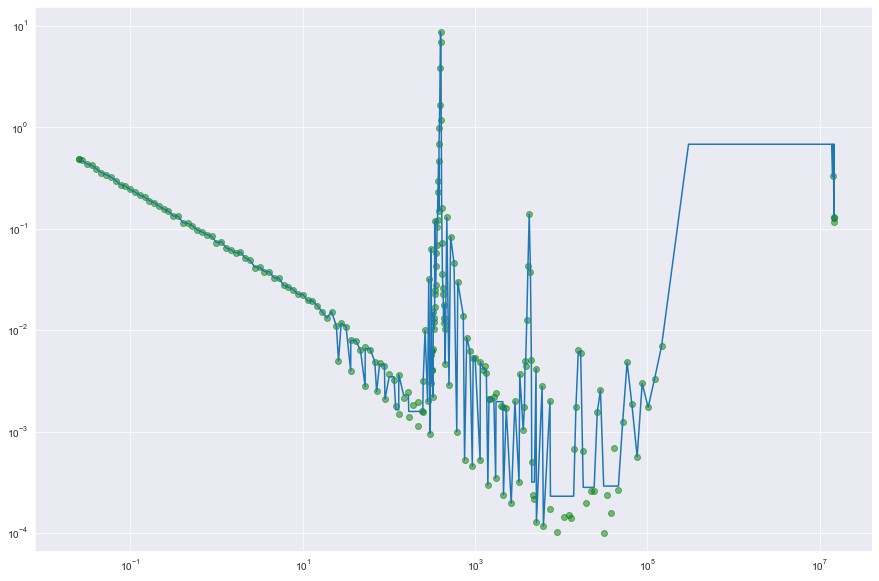

In [150]:
plt.figure(figsize=(15,10))
test_df, pred = exfor_utils.make_predictions_outside(df, 17, 35, "MT_103", xs_tree_cle, None, scaler, to_scale, 
                                            0.025, 1.5E7, 50, log_e=log_E)

We will now use the entire `EXFOR` dataset and all features.

In [146]:
from Utilities import EXFOR_utilities as exfor_utils
from Utilities import ENDF_utilities as endf_utils
from Utilities import Plotting_utilities as plot_utils
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
print("Finish importing scripts.")

Finish importing scripts.


In [143]:
xs_tree = tree.DecisionTreeRegressor(max_depth=300)
xs_tree.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=300,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
exfor_utils.predicting_nuclear_xs(df, 17, 35, "MT_103", xs_tree_cle, to_scale, scaler, 
                      endf=endf_cl, E_min=5, E_max=7, N=0, error=True, log_e=log_E, clf_type="Other")

Finish importing scripts.
Extracting samples from dataframe.
EXFOR Extracted Dataframe has shape:  (215, 126)


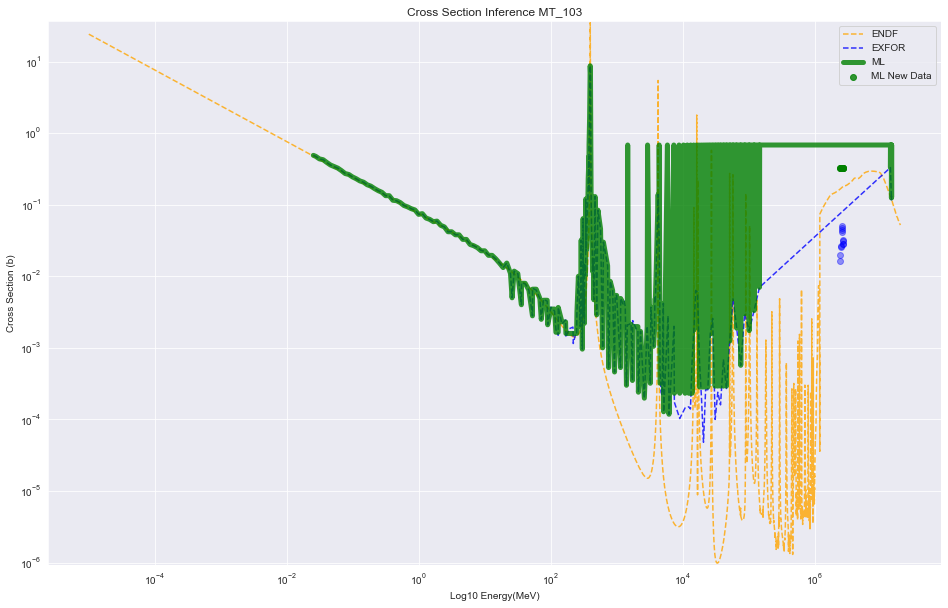

C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:249: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000001900917A948>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  y_hat3[0].flatten()))


[0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33]


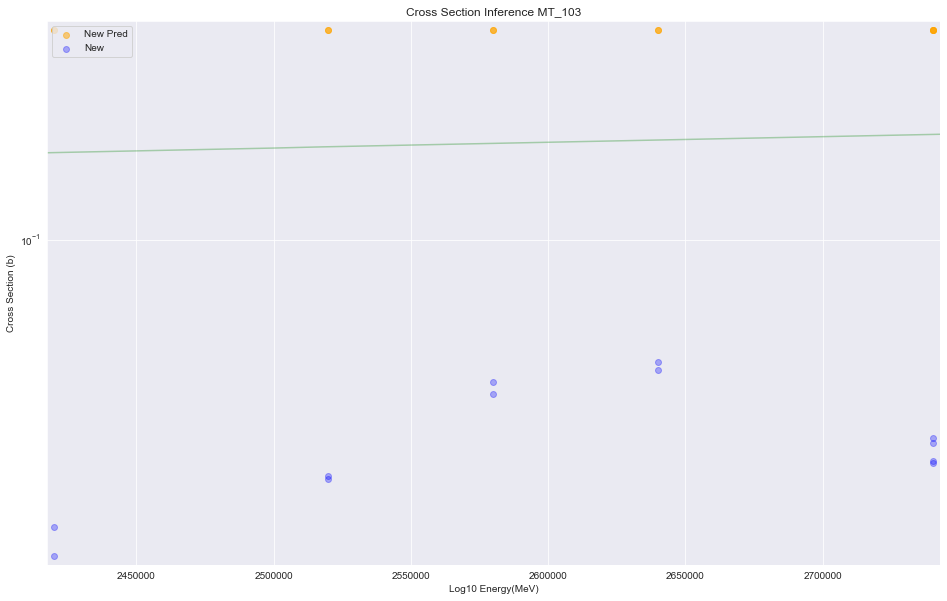

ENDF vs EXFOR:
The MSE is:  1.2276432469148273
The MAE is:  0.1584792812410853
ML vs EXFOR:
The MSE is:  4.690387838759698e-07
The MAE is:  0.00011769674418604657
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.02009284974699579
The MAE is:  0.14145558333333333
NEW DATA: ML vs EXFOR:
The MSE is:  0.08849187416666666
The MAE is:  0.2972916666666667


In [370]:
from Utilities import EXFOR_utilities as exfor_utils
from Utilities import ENDF_utilities as endf_utils
from Utilities import Plotting_utilities as plot_utils
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
print("Finish importing scripts.")
%matplotlib inline 
# %matplotlib qt

cl_kwargs =  {"Z":17, "A":35, "MT":"MT_103", "clf_type":None, "scaler":scaler, "to_scale":to_scale, 
              "E_min":0, "E_max":1.5E7, "N":10000, "log_e":log_E, "focus":True, "error":True}

# cl_kwargs =  {"Z":17, "A":35, "MT":"MT_103", "clf_type":None, "scaler":scaler, "to_scale":to_scale, 
#               "E_min":2000000, 
#               "E_max":2800000, 
#               "N":1000, "log_e":log_E, "focus":True, "error":True}

y_hat3 = exfor_utils.predicting_nuclear_xs(df, clf=xs_tree_cle, new_data=new_cl_data, endf=endf_cl, **cl_kwargs)

# exfor_utils.predicting_nuclear_xs(df, 17, 35, "MT_103", neigh, to_scale, scaler, new_data=new_cl_data, 
#                       endf=endf_cl, E_min=-2, E_max=8, N=20, error=True, log_e=log_E, clf_type="Other")

Extracting samples from dataframe.
EXFOR Extracted Dataframe has shape:  (215, 126)
1


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:278: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000018FABE9D2C8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ('ENDF', 'EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='lower left')


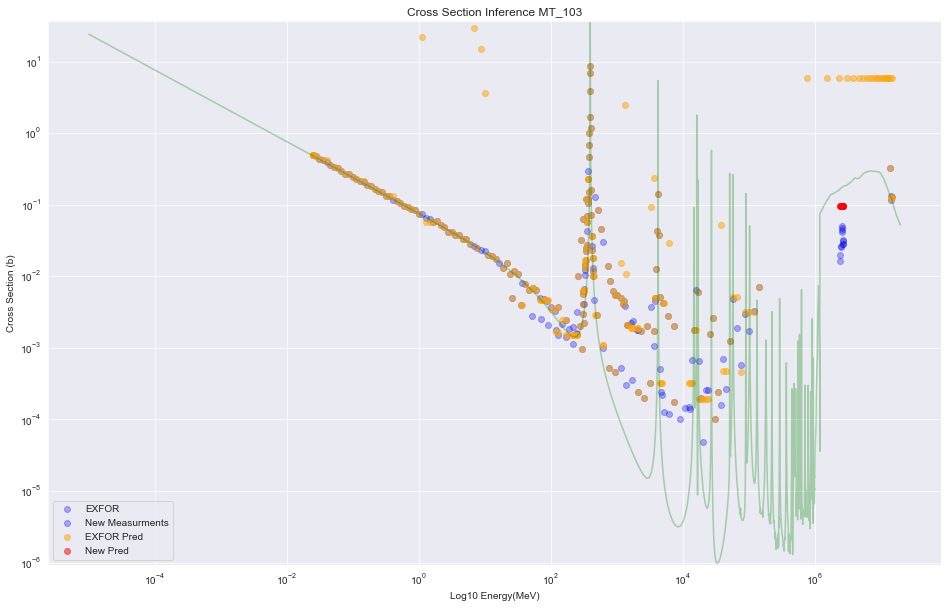

C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:331: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000019006EC2708>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((pred_unseen, unseen, endf_data), ("New Pred", "New", "ENDF"), loc='upper left')


[0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095]


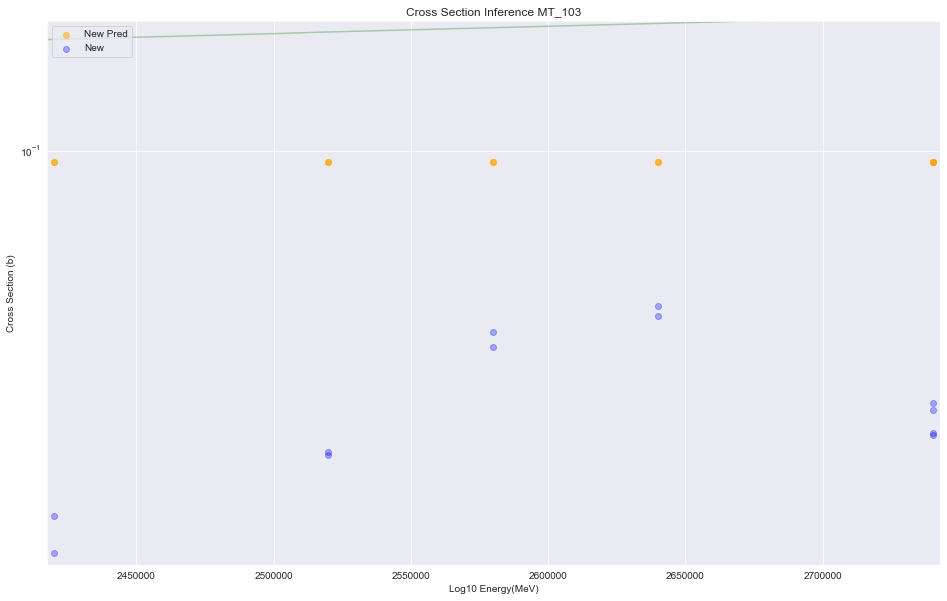

ENDF vs EXFOR:
The MSE is:  1.2276432469148273
The R2 Score is:  -0.8608557151644416
The MAE is:  0.1584792812410853
XS Tree vs EXFOR:
The MSE is:  16.732615320732773
The R2 Score is:  -24.363217634669994
The MAE is:  0.549390588482835
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.02009284974699579
The R2 Score is:  -182.43085032217655
The MAE is:  0.14145558333333333
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.003989790833333333
The R2 Score is:  -35.42344089470844
The MAE is:  0.06229166666666666


In [151]:
exfor_utils.predicting_nuclear_xs(df, 17, 35, "MT_103", xs_tree, to_scale, scaler, new_data=new_cl_data, 
                      endf=endf_cl, E_min=-4, E_max=7, N=20, error=True, log_e=log_E, clf_type="Other")

Extracting samples from dataframe.
EXFOR Extracted Dataframe has shape:  (215, 126)


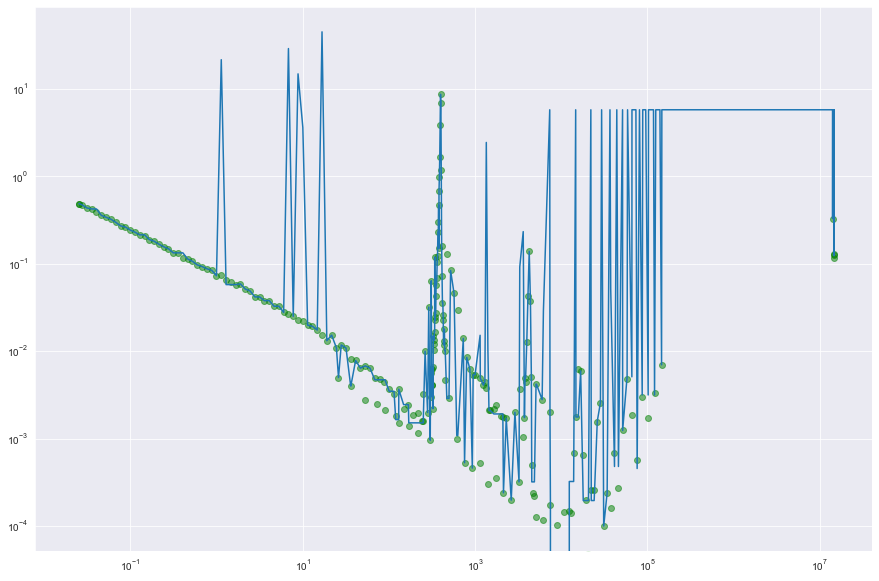

In [148]:
plt.figure(figsize=(15,10))
pred = exfor_utils.make_predictions_outside(df, 17, 35, "MT_103", xs_tree, None, scaler, to_scale, 
                                            0.025, 1.5E7, 2000, log_e=log_E)

# XGBoost

In [343]:
from Utilities import EXFOR_utilities as exfor_utils
from Utilities import ENDF_utilities as endf_utils
from Utilities import Plotting_utilities as plot_utils
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
print("Finish importing scripts.")

Finish importing scripts.


In [324]:
import xgboost as xgb

In [325]:
dtrain = xgb.DMatrix(x_train.values, y_train.values)
dtest = xgb.DMatrix(x_test.values, y_test.values)

evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [326]:
# specify parameters via map
param = {'max_depth':50, 'eta':0.3, 'objective':'reg:squarederror', "booster":"gbtree", 
         "tree_method":"auto", "verbosity":2, "gamma":0, "lambda":1}
num_round = 50

progress = dict()

In [327]:
bst = xgb.train(param, dtrain, num_round, evallist, evals_result=progress, 
                verbose_eval=True, early_stopping_rounds=5)

[15:50:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 367860 extra nodes, 0 pruned nodes, max_depth=50
[0]	train-rmse:449451	eval-rmse:457853
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 5 rounds.
[15:50:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488164 extra nodes, 0 pruned nodes, max_depth=50
[1]	train-rmse:332653	eval-rmse:358632
[15:51:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 648484 extra nodes, 0 pruned nodes, max_depth=50
[2]	train-rmse:252272	eval-rmse:300380
[15:52:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 846820 extra nodes, 0 pruned nodes, max_depth=50
[3]	train-rmse:194864	eval-rmse:267103
[15:53:03] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1049010 extra nodes, 0 pruned nodes, max_depth=50
[4]	train-rmse:155063	eval-rmse:254315
[15:53:51] INFO: src/tree/updater_prune.cc:74: 

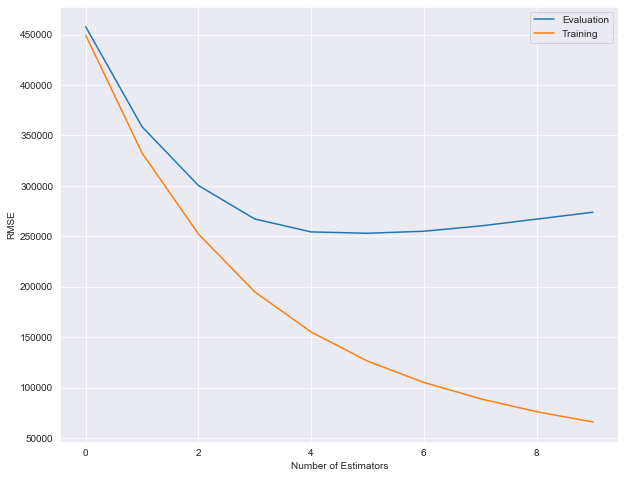

In [335]:
plot_utils.plot_xgb_training(progress)

Extracting samples from dataframe.
EXFOR Extracted Dataframe has shape:  (215, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:284: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021B3BEEA848>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  maximum_y = all_y.max() + all_y.max() * 0.05


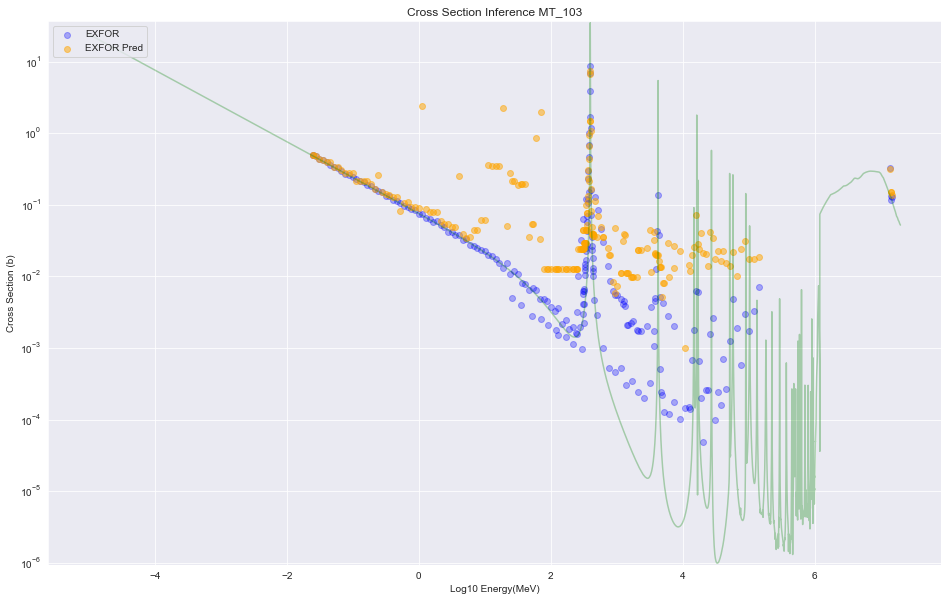

ENDF vs EXFOR:
The MSE is:  1.2276460922438313
The R2 Score is:  -0.8608600281004284
The MAE is:  0.158588439148062
XS Tree vs EXFOR:
The MSE is:  0.10911927797913516
The R2 Score is:  0.8345975245069068
The MAE is:  0.08337593184028448


In [341]:
exfor_utils.predicting_nuclear_xs(df, 17, 35, "MT_103", bst, to_scale, scaler, 
                      endf=endf_cl, E_min=5, E_max=7, N=0, error=True, log_e=log_E, clf_type="xgb")

In [340]:
from Utilities import EXFOR_utilities as exfor_utils
from Utilities import ENDF_utilities as endf_utils
from Utilities import Plotting_utilities as plot_utils
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
print("Finish importing scripts.")

Finish importing scripts.


Extracting samples from dataframe.
EXFOR Extracted Dataframe has shape:  (215, 127)
Expanded Dataset has shape:  (90000, 125)


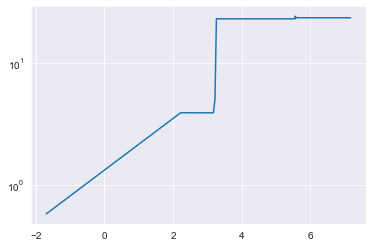

In [346]:
pred, hello, copy = exfor_utils.make_predictions_outside(df, 17, 35, "MT_103", bst, "xgb", scaler, 
                                                         to_scale, 0.020, 1.5E7, 90000, log_e=log_E)

In [60]:
bst.save_model('./Models/XGBoost/0001.model')

In [61]:
bst = xgb.Booster()  # init model
bst.load_model('./Models/XGBoost/0001.model')  # load data

# For Looping

In [57]:
max_depths = [4, 5]
learning_rates = [0.3, 0.1, ]
estimators = [3, 7]

In [58]:
all_models_progress = {}
all_models_best_iter = {}
all_models_best_score = {}
models = {}

In [90]:
models.keys()

dict_keys(['3_est_4_depth_0.3_lr', '7_est_4_depth_0.3_lr', '3_est_4_depth_0.1_lr', '7_est_4_depth_0.1_lr', '3_est_5_depth_0.3_lr', '7_est_5_depth_0.3_lr', '3_est_5_depth_0.1_lr', '7_est_5_depth_0.1_lr'])

In [92]:
models[max(all_models_best_score, key=all_models_best_score.get)]

In [59]:
for md in max_depths:
    for lr in learning_rates:
        for es in estimators:
            progress = {}
            param = {'max_depth':md, 'eta':lr, 'objective':'reg:squarederror', "booster":"gbtree", 
                    "tree_method":"auto", "verbosity":2, "gamma":0, "lambda":1}
            num_round = es
            bst = xgb.train(param, dtrain, num_round, evallist, evals_result=progress, 
                            verbose_eval=True, early_stopping_rounds=5)
            all_models_progress[str(es) + "_est_" + str(md) + "_depth_" + str(lr) + "_lr"] = progress
            all_models_best_iter[str(es) + "_est_" + str(md) + "_depth_" + str(lr) + "_lr"] = bst.best_iteration
            all_models_best_score[str(es) + "_est_" + str(md) + "_depth_" + str(lr) + "_lr"] = bst.best_score
            models[str(es) + "_est_" + str(md) + "_depth_" + str(lr) + "_lr"] = bst

[16:12:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:445190	eval-rmse:497312
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 5 rounds.
[16:12:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:336083	eval-rmse:390242
[16:12:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:264254	eval-rmse:322646
[16:12:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:445190	eval-rmse:497312
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 5 rounds.
[16:12:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes

In [62]:
max(all_models_best_iter, key=all_models_best_iter.get)

'7_est_4_depth_0.3_lr'

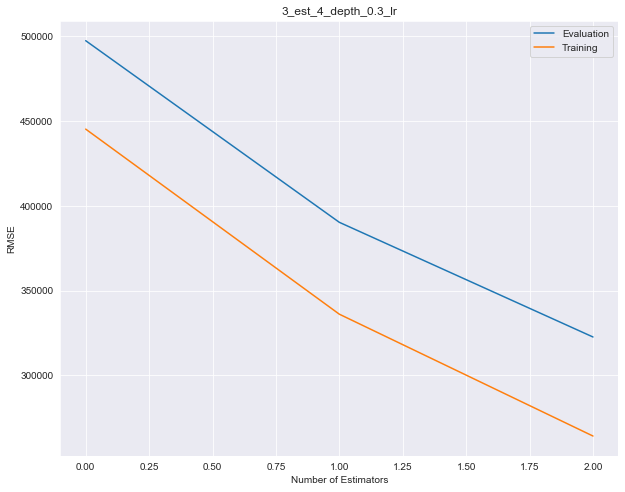

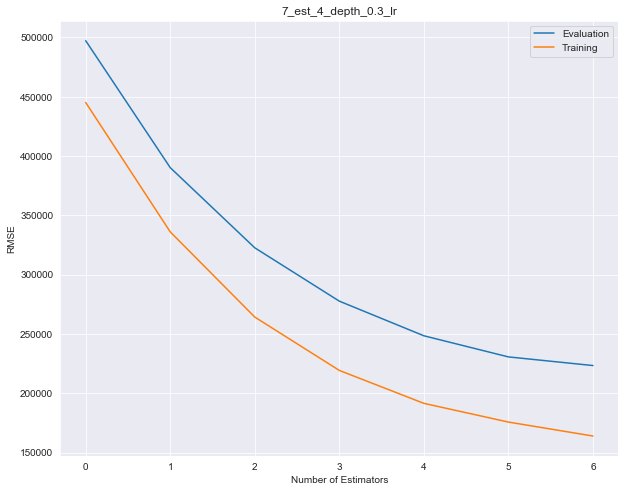

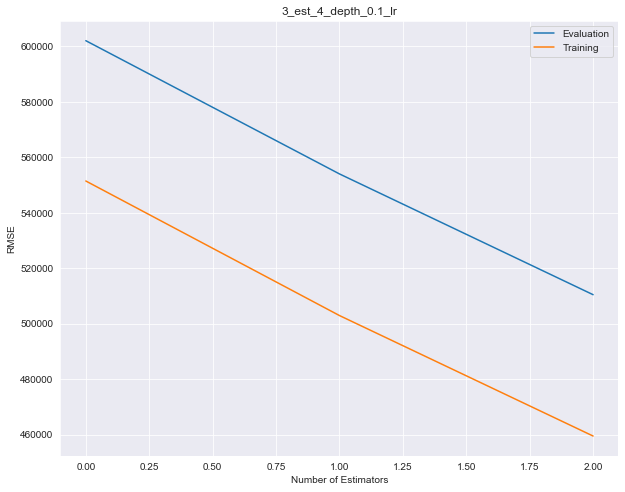

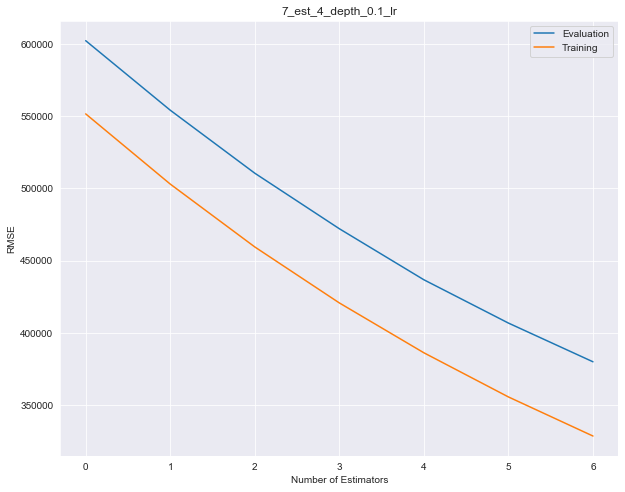

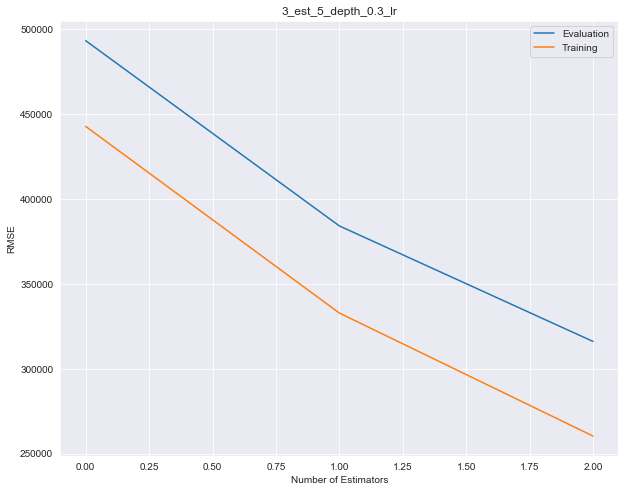

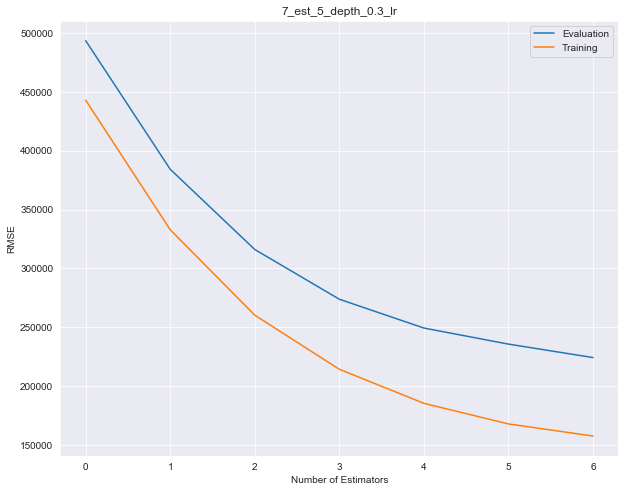

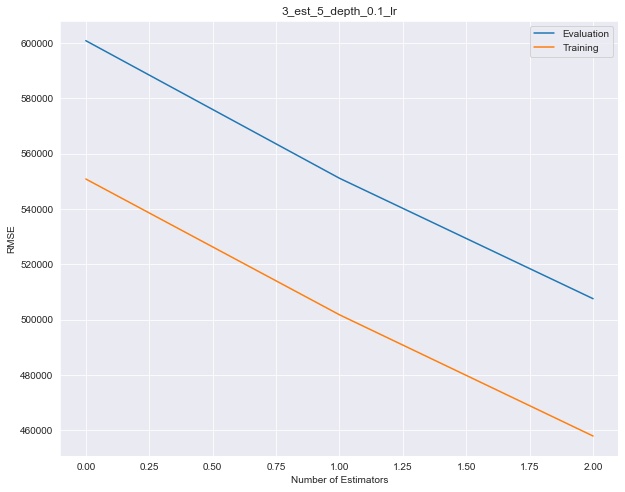

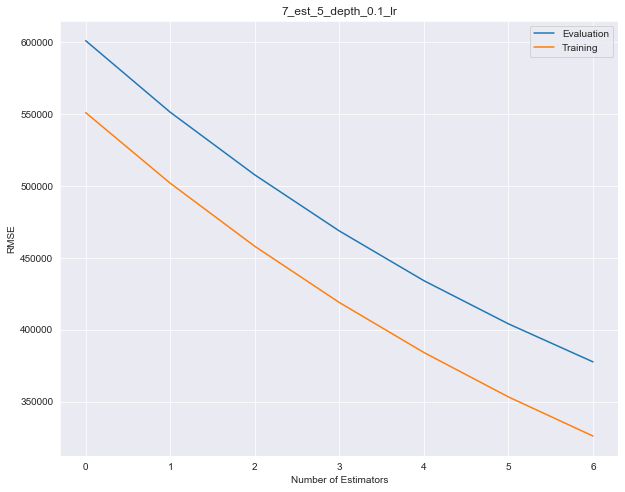

In [73]:
for md in max_depths:
    for lr in learning_rates:
        for es in estimators:
            name = str(es) + "_est_" + str(md) + "_depth_" + str(lr) + "_lr"
            plot_utils.plot_xgb_training(all_models_progress[name], title=name, 
                                         save=False, path=("./Figures/" + name + ".png"))

Extracting samples from dataframe.
Final Dataframe has shape:  (172, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:277: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021A97B64988>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')


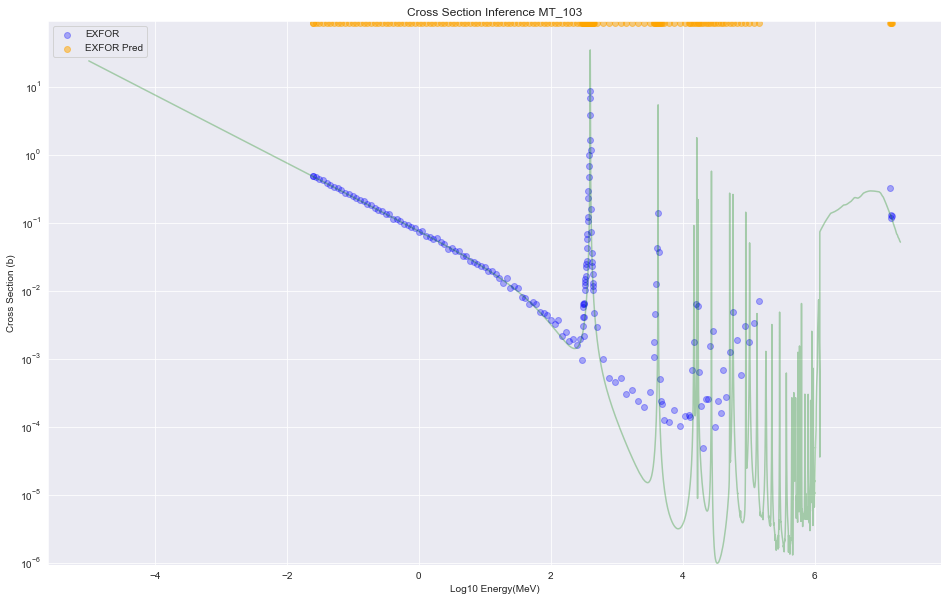

ENDF vs EXFOR:
The MSE is:  1.5342480222442398
The R2 Score is:  -0.8771490798440222
The MAE is:  0.19411576435174419
XS Tree vs EXFOR:
The MSE is:  7719.335178537776
The R2 Score is:  -9443.589608271976
The MAE is:  87.8550957527707
Extracting samples from dataframe.
Final Dataframe has shape:  (172, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:277: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021AFFDBA348>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')


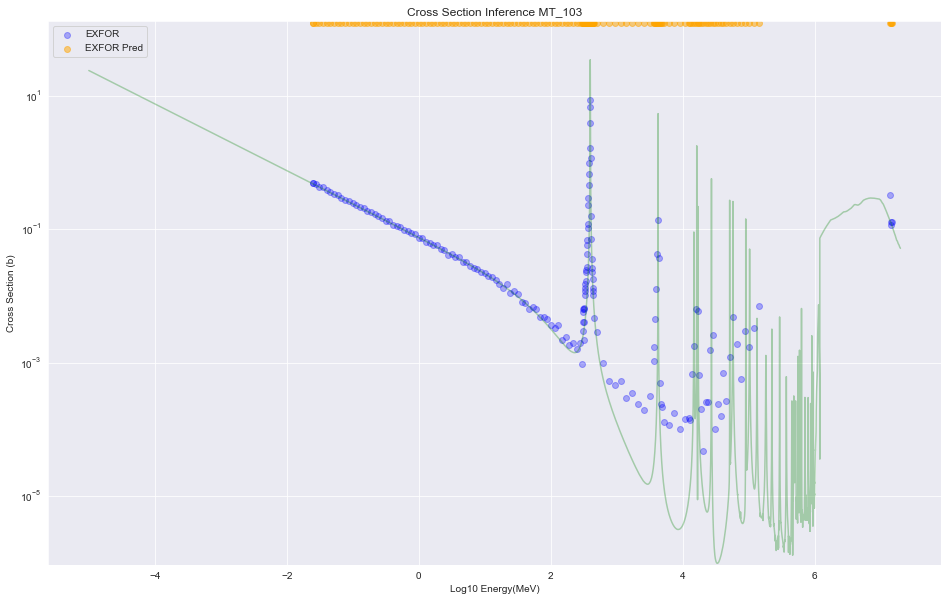

ENDF vs EXFOR:
The MSE is:  1.5342480222442398
The R2 Score is:  -0.8771490798440222
The MAE is:  0.19411576435174419
XS Tree vs EXFOR:
The MSE is:  15812.711517660602
The R2 Score is:  -19345.81775362283
The MAE is:  125.7453545418332
Extracting samples from dataframe.
Final Dataframe has shape:  (172, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:277: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021A9B331048>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')


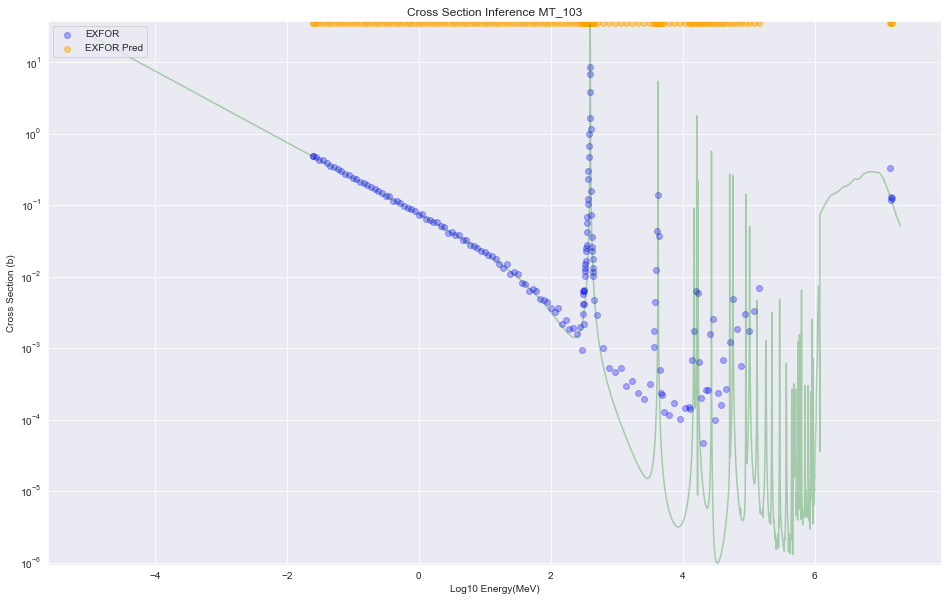

ENDF vs EXFOR:
The MSE is:  1.5342480222442398
The R2 Score is:  -0.8771490798440222
The MAE is:  0.19411576435174419
XS Tree vs EXFOR:
The MSE is:  1277.6950613263673
The R2 Score is:  -1562.257096581893
The MAE is:  35.7334259834836
Extracting samples from dataframe.
Final Dataframe has shape:  (172, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:277: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021AFFCE83C8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')


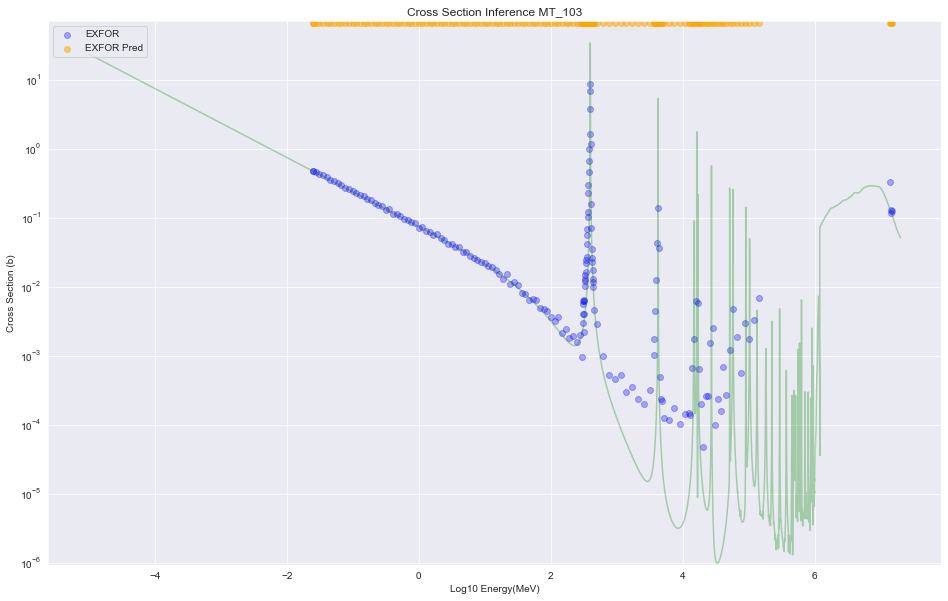

ENDF vs EXFOR:
The MSE is:  1.5342480222442398
The R2 Score is:  -0.8771490798440222
The MAE is:  0.19411576435174419
XS Tree vs EXFOR:
The MSE is:  4695.538686386082
The R2 Score is:  -5743.9812525282105
The MAE is:  68.5180367317746
Extracting samples from dataframe.
Final Dataframe has shape:  (172, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:277: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021B002AA288>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')


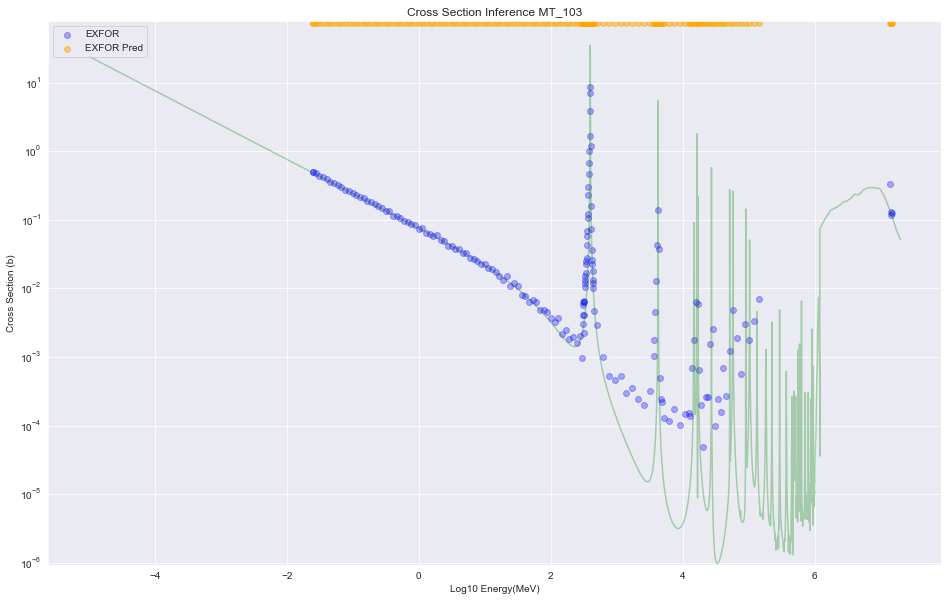

ENDF vs EXFOR:
The MSE is:  1.5342480222442398
The R2 Score is:  -0.8771490798440222
The MAE is:  0.19411576435174419
XS Tree vs EXFOR:
The MSE is:  5549.179423777401
The R2 Score is:  -6788.408816702315
The MAE is:  74.48732841878632
Extracting samples from dataframe.
Final Dataframe has shape:  (172, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:277: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021AFFC88248>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')


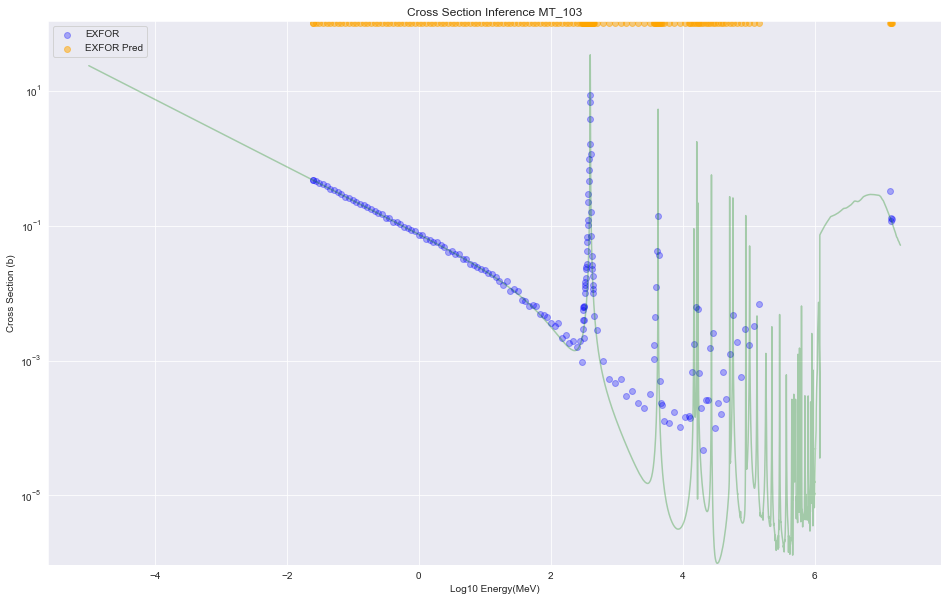

ENDF vs EXFOR:
The MSE is:  1.5342480222442398
The R2 Score is:  -0.8771490798440222
The MAE is:  0.19411576435174419
XS Tree vs EXFOR:
The MSE is:  10990.733842768701
The R2 Score is:  -13446.138676825678
The MAE is:  104.83280266195041
Extracting samples from dataframe.
Final Dataframe has shape:  (172, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:277: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021AFFCC5088>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')


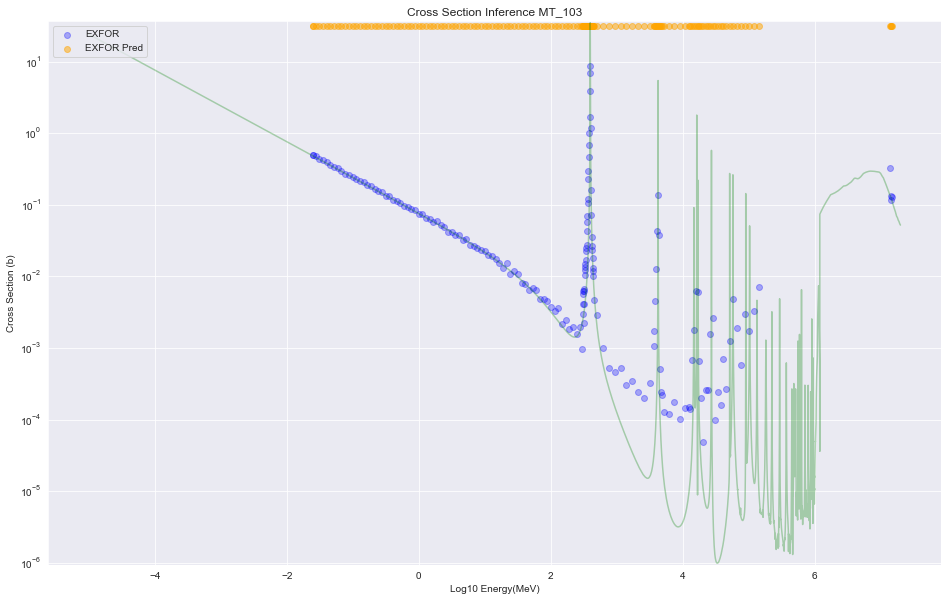

ENDF vs EXFOR:
The MSE is:  1.5342480222442398
The R2 Score is:  -0.8771490798440222
The MAE is:  0.19411576435174419
XS Tree vs EXFOR:
The MSE is:  955.4836741585608
The R2 Score is:  -1168.0321732526265
The MAE is:  30.89767540364962
Extracting samples from dataframe.
Final Dataframe has shape:  (172, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:277: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021A994A2D08>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')


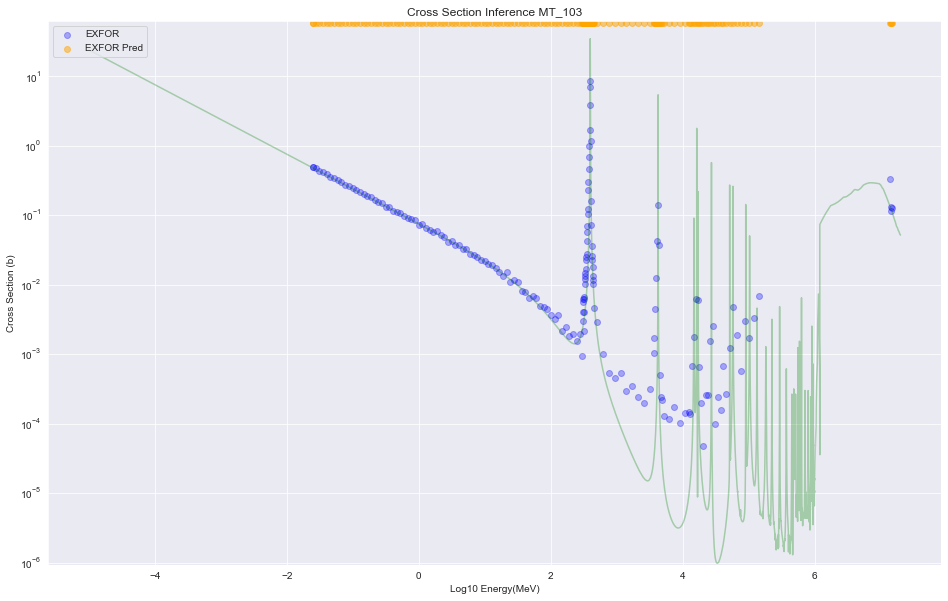

ENDF vs EXFOR:
The MSE is:  1.5342480222442398
The R2 Score is:  -0.8771490798440222
The MAE is:  0.19411576435174419
XS Tree vs EXFOR:
The MSE is:  3506.4891867018623
The R2 Score is:  -4289.181805593738
The MAE is:  59.20871437459688


In [74]:
for md in max_depths:
    for lr in learning_rates:
        for es in estimators:
            name = str(es) + "_est_" + str(md) + "_depth_" + str(lr) + "_lr"
            exfor_utils.predicting_nuclear_xs(df, "MT_103", 17, 35, models[name], 
                                              to_scale, scaler, endf=endf_cl, E_min=-4, E_max=7, N=0, 
                                              error_metrics=True, log_e=log_E, clf_type="xgb", save=False,
                                              path=("./Figures/Chlorine_Predictions/" + name + "_xs.png"
                                              path_add=("./Figures/Chlorine_Predictions/" + name + "_additional_xs.png")

In [ ]:
for md in max_depths:
    for lr in learning_rates:
        for es in estimators:
            name = str(es) + "_est_" + str(md) + "_depth_" + str(lr) + "_lr"
            exfor_utils.predicting_nuclear_xs(df, "MT_1", 92, 235, models[name], to_scale, scaler, 
                                              endf=endf_u, E_min=-4, E_max=7, N=0, error_metrics=True, 
                                              log_e=log_E, clf_type="xgb", save=False,
                                              path=("./Figures/Uranium_Predictions/" + name + "_xs.png"
                                              path_add=("./Figures/Uranium_Predictions/" + name + "_additional_xs.png"))

Extracting samples from dataframe.
Final Dataframe has shape:  (172, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:270: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021B0037FE48>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ('ENDF', 'EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='lower left')


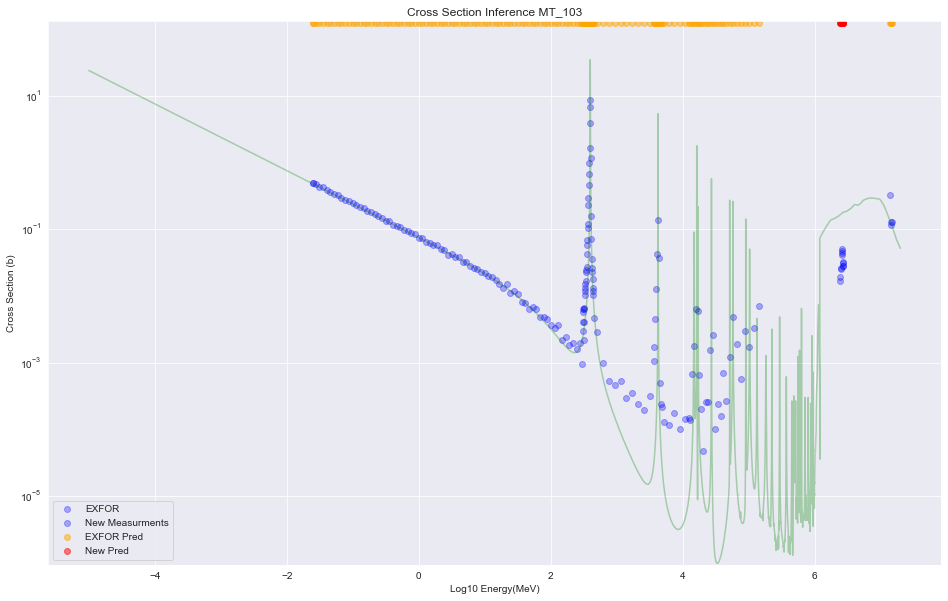

C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:320: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021B011F5548>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((pred_unseen, unseen, endf_data), ("New Pred", "New", "ENDF"), loc='upper left')


[125.950775 125.950775 125.950775 125.950775 125.950775 125.950775
 125.950775 125.950775 125.950775 125.950775 125.950775 125.950775]


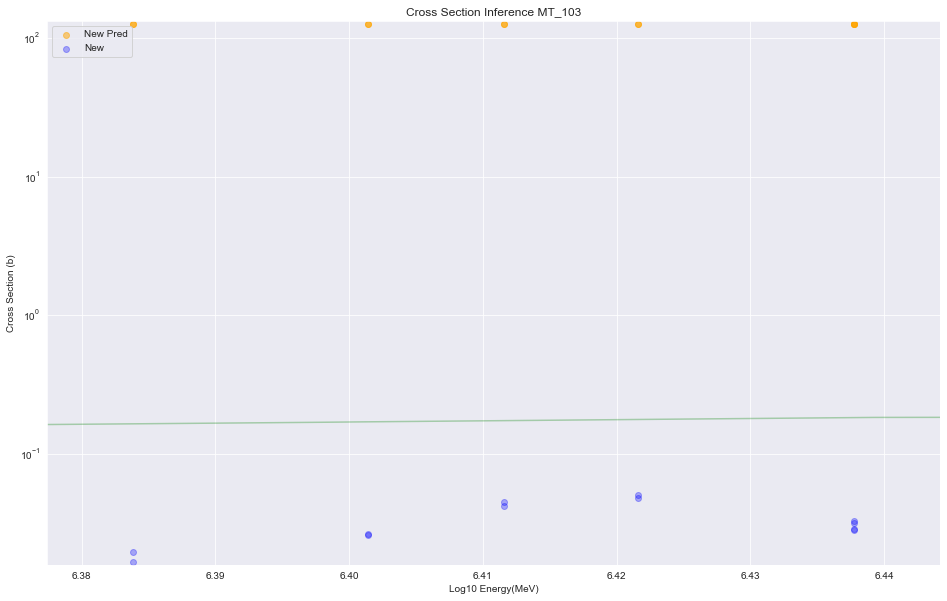

ENDF vs EXFOR:
The MSE is:  1.5342480222442398
The R2 Score is:  -0.8771490798440222
The MAE is:  0.19411576435174419
XS Tree vs EXFOR:
The MSE is:  15812.711517660602
The R2 Score is:  -19345.81775362283
The MAE is:  125.7453545418332
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.02009284974699579
The R2 Score is:  -182.43085032217655
The MAE is:  0.14145558333333333
NEW DATA: ENDF vs EXFOR:
The MSE is:  15855.359659500267
The R2 Score is:  -144746122.17951152
The MAE is:  125.91806681315103


In [68]:
exfor_utils.predicting_nuclear_xs(df, "MT_103", 17, 35, models["7_est_4_depth_0.3_lr"], to_scale, scaler, additional_data=new_data, 
                      endf=endf_cl, E_min=-4, E_max=7, N=0, error_metrics=True, log_e=log_E, clf_type="xgb")

Extracting samples from dataframe.
Final Dataframe has shape:  (40523, 127)


C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:277: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021AFFCDA888>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')


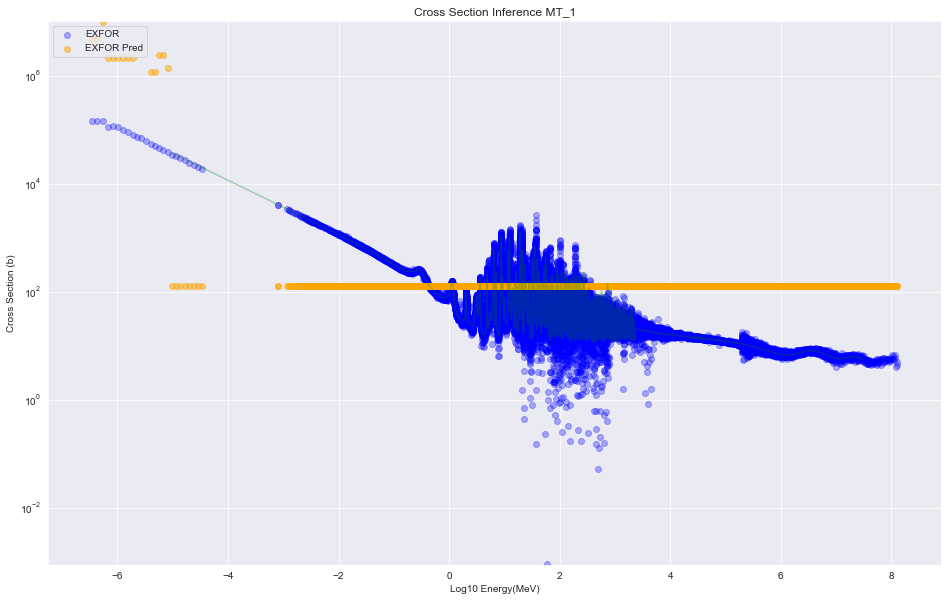

ENDF vs EXFOR:
The MSE is:  3434.7810112653337
The R2 Score is:  0.9738543983402932
The MAE is:  13.758311581044602
XS Tree vs EXFOR:
The MSE is:  4307558340.455998
The R2 Score is:  -1098.8138220207782
The MAE is:  1103.6145206770314


In [69]:
exfor_utils.predicting_nuclear_xs(df, "MT_1", 92, 235, models["7_est_4_depth_0.3_lr"], to_scale, scaler, 
                      endf=endf_u, E_min=-4, E_max=7, N=0, error_metrics=True, log_e=log_E, clf_type="xgb")

# Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
regr = RandomForestRegressor(n_estimators=10, max_depth=200, n_jobs=-1, verbose=2)
regr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=200, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:208: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000020032026188>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ('ENDF', 'EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='lower left')


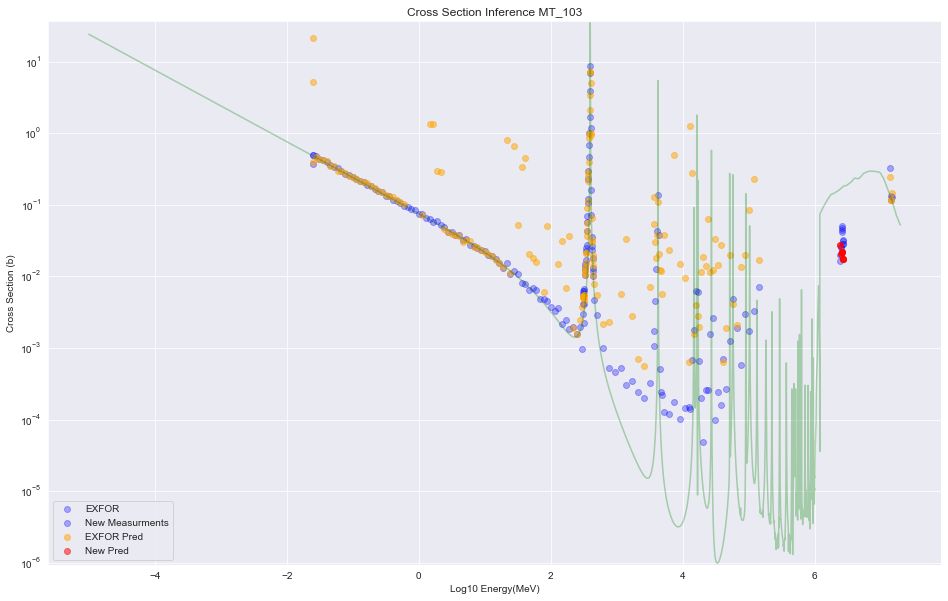

C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:255: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000200322DB048>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((pred_unseen, unseen, endf_data), ("New Pred", "New", "ENDF"), loc='upper left')


[0.02697  0.02697  0.02039  0.02039  0.02164  0.02164  0.02164  0.02164
 0.017698 0.017698 0.017698 0.017698]


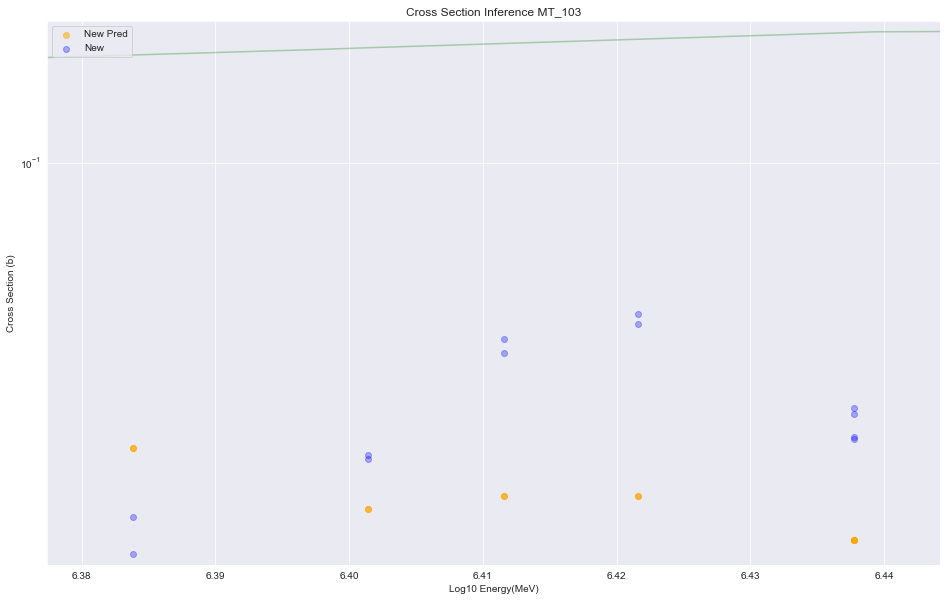

ENDF vs EXFOR:
The MSE is:  1.5254315355274362
The R2-Score is:  -0.8768535376442768
XS Tree vs EXFOR:
The MSE is:  74287.30722753816
The R2-Score is:  -91400.28030974782
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.02009284974699579
The R2-Score is:  -182.43085032217655
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.0002725194013333334
The R2-Score is:  -1.487873355213734


In [45]:
exfor_util.predicting_nuclear_xs(df, "MT_103", 17, 35, regr, to_scale, scaler, additional_data=new_data, 
                      endf=endf_cl, E_min=0.10, E_max=16, N=100, error_metrics=True, log_e=log_E)

# Adaboost Regressor

In [46]:
from sklearn.ensemble import AdaBoostRegressor

In [47]:
adaboost = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth=200), n_estimators=100)
adaboost.fit(x_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=200,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                

C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:208: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000200321FB6C8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ('ENDF', 'EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='lower left')


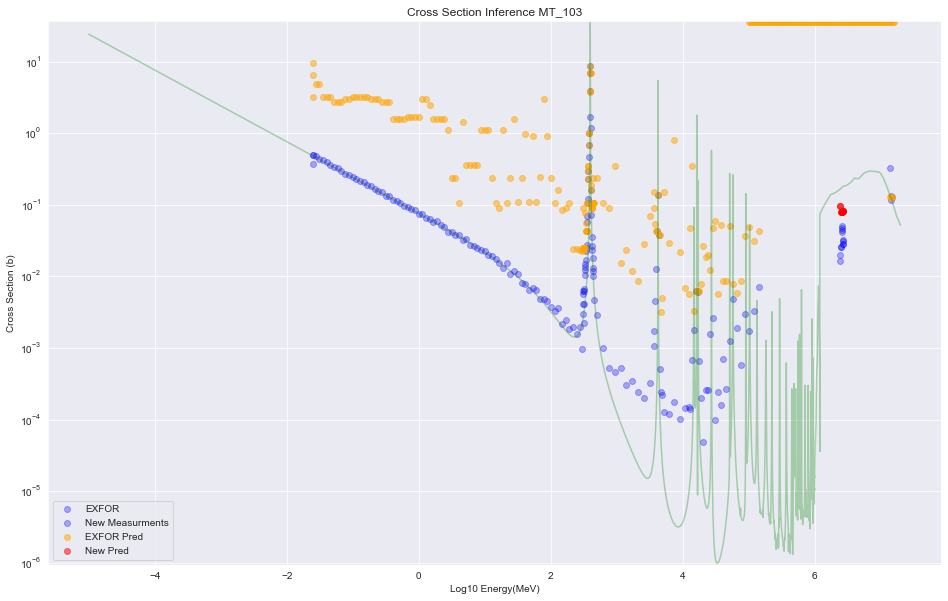

C:\Users\Pedro\Desktop\ML_Nuclear_Data\Utilities\EXFOR_utilities.py:255: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000020032478FC8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((pred_unseen, unseen, endf_data), ("New Pred", "New", "ENDF"), loc='upper left')


[0.096  0.096  0.0784 0.0784 0.0784 0.0784 0.0784 0.0784 0.0806 0.0806
 0.0806 0.0806]


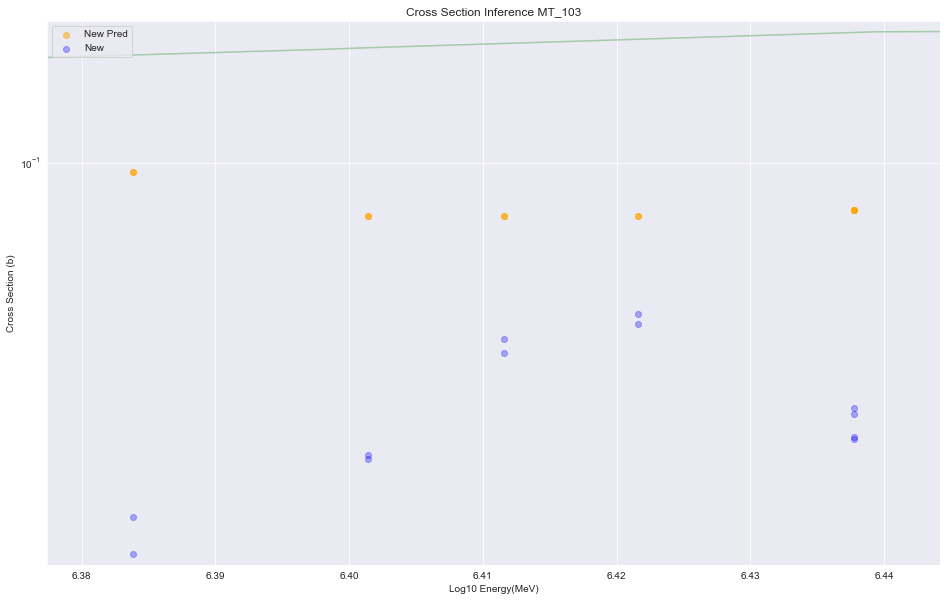

ENDF vs EXFOR:
The MSE is:  1.5254315355274362
The R2-Score is:  -0.8768535376442768
XS Tree vs EXFOR:
The MSE is:  2.467182834844157
The R2-Score is:  -2.035561232180392
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.02009284974699579
The R2-Score is:  -182.43085032217655
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.0026751075000000005
The R2-Score is:  -23.42148573283385


In [48]:
exfor_util.predicting_nuclear_xs(df, "MT_103", 17, 35, adaboost, to_scale, scaler, additional_data=new_data, 
                      endf=endf_cl, E_min=0.10, E_max=16, N=100, error_metrics=True, log_e=log_E)

# Save Model

In [296]:
# from joblib import dump, load
# dump(BestRR1, '../ML_Data/Models/Decision_Trees/DT_GS.joblib') 

['../ML_Data/Models/Decision_Trees/DT_GS.joblib']

In [297]:
# clf = load('../ML_Data/Models/Decision_Trees/DT_GS.joblib') 